# XGBoost

# Sección 1: Configuración Inicial y Preparación de Datos

In [ ]:
#!pip install imbalanced-learn xgboost -q

In [2]:
# === Cell 0: Comprueba versión de xgboost ===
import xgboost
print("xgboost version:", xgboost.__version__)

xgboost version: 2.1.4


In [3]:
import imblearn
print(imblearn.__version__)


0.12.4


## 1. Librerias

In [4]:

# 1) IMPORTS
import time, joblib, pandas as pd, numpy as np, xgboost as xgb
from   sklearn.model_selection    import train_test_split, GridSearchCV, StratifiedKFold
from   sklearn.compose            import ColumnTransformer
from   sklearn.preprocessing      import OneHotEncoder, StandardScaler
from   sklearn.impute             import SimpleImputer
from   sklearn.pipeline           import Pipeline as SKPipeline
from   imblearn.pipeline          import Pipeline as ImbPipeline
from   imblearn.over_sampling     import SMOTE, ADASYN
from collections import defaultdict
from sklearn.metrics import (
    recall_score, precision_score, f1_score,
    roc_auc_score, average_precision_score
)
import pandas as pd, numpy as np, xgboost as xgb, time, matplotlib.pyplot as plt, seaborn as sns

from   sklearn.metrics            import (
        precision_score, recall_score, f1_score,
        roc_auc_score, average_precision_score)

## 2. Cargar Datos

In [5]:
# 2) CARGA Y SPLIT (70 % train, 15 % val, 15 % test)
df   = pd.read_csv(r"C:\Users\DELL\Desktop\Aprendizaje_de_Maquina\credit_risk_the_end.csv")
X,y  = df.drop("incumplimiento_credito", axis=1), df["incumplimiento_credito"]

X_tr, X_tmp, y_tr, y_tmp = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)
X_val, X_te,  y_val, y_te = train_test_split(X_tmp, y_tmp, test_size=0.50, stratify=y_tmp, random_state=42)

## 3.Preprocesamiento de Datos

In [6]:
# 3) PREPROCESADOR (One-Hot a categóricas, escala a numéricas)
cat_cols = X_tr.select_dtypes(include=["object","category"]).columns.tolist()
num_cols = X_tr.select_dtypes(include=["int64","float64"]).columns.tolist()

cat_pipe = SKPipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])
num_pipe = SKPipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("sc",  StandardScaler())
])

preproc = ColumnTransformer([
    ("cat", cat_pipe, cat_cols),
    ("num", num_pipe, num_cols)
])

# Sección 2: Definición de la Arquitectura y GridSearch

## 1.Pipeline y GridSearch de Hiperparámetros

In [7]:
# 4) PIPELINE + GRIDSEARCH (sin early-stopping)
scale_pos = (y_tr==0).sum() / (y_tr==1).sum()
base_xgb  = xgb.XGBClassifier(
              objective="binary:logistic",
              tree_method="hist",
              eval_metric="logloss",
              random_state=42)

pipe = ImbPipeline([
    ("pre",      preproc),
    ("sample",   SMOTE(random_state=42)),      # se sobreescribe en grid
    ("clf",      base_xgb)
])

param_grid = [
    # SMOTE
    {
        "sample": [SMOTE(random_state=42)],
        "clf__scale_pos_weight": [1],              # NO se usa weight
        "clf__max_depth":        [3, 6],
        "clf__learning_rate":    [0.1, 0.05, 0.01],
        "clf__n_estimators":     [200, 400],
        "clf__subsample":        [0.8, 1.0],
        "clf__colsample_bytree": [0.8, 1.0]
    },
    # ADASYN
    {
        "sample": [ADASYN(random_state=42)],
        "clf__scale_pos_weight": [1],              # idem
        "clf__max_depth":        [3, 6],
        "clf__learning_rate":    [0.1, 0.05, 0.01],
        "clf__n_estimators":     [200, 400],
        "clf__subsample":        [0.8, 1.0],
        "clf__colsample_bytree": [0.8, 1.0]
    },
    # Sin remuestreo  (balance via scale_pos_weight)
    {
        "sample": ["passthrough"],
        "clf__scale_pos_weight": [scale_pos],      # calculado antes
        "clf__max_depth":        [3, 6],
        "clf__learning_rate":    [0.1, 0.05, 0.01],
        "clf__n_estimators":     [200, 400],
        "clf__subsample":        [0.8, 1.0],
        "clf__colsample_bytree": [0.8, 1.0]
    }
]


cv   = StratifiedKFold(5, shuffle=True, random_state=42)
grid = GridSearchCV(pipe, param_grid, scoring="recall",
                    cv=cv, n_jobs=-1, verbose=2, return_train_score=True)


tic = time.time()
grid.fit(X_tr, y_tr)
print(f"✅ GridSearch terminado en {time.time()-tic:.1f}s  –  Mejor recall CV: {grid.best_score_:.4f}")
print("🔑 Parámetros óptimos:", grid.best_params_)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
✅ GridSearch terminado en 579.5s  –  Mejor recall CV: 0.6687
🔑 Parámetros óptimos: {'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.01, 'clf__max_depth': 3, 'clf__n_estimators': 200, 'clf__scale_pos_weight': 10.699978691668443, 'clf__subsample': 0.8, 'sample': 'passthrough'}


# Sección 3: Evaluación Básica del Modelo

## 1.Tabla comparativa de métricas

c:\Users\DELL\anaconda3\envs\KrakenData\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\DELL\anaconda3\envs\KrakenData\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


,Recall,Precision,F1-score,AUC,AvgPrec,Tiempo (s)
Técnica,,,,,,
passthrough,0.655100,0.158900,0.255800,0.727300,0.219200,0.600000
SMOTE,0.244500,0.218300,0.230700,0.697100,0.174100,1.600000
ADASYN,0.206800,0.208000,0.207400,0.693700,0.168700,1.400000



🔝 Mejor modelo por Recall: **passthrough**


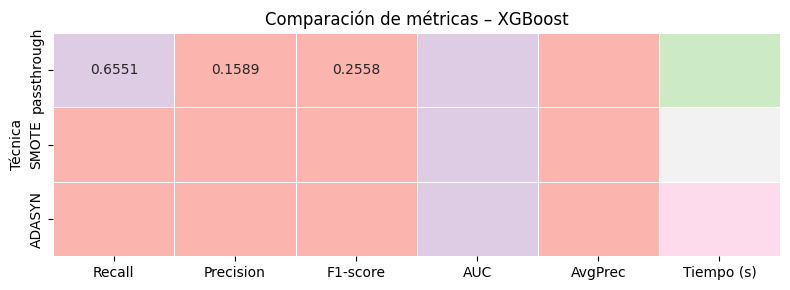

In [8]:
# ------------------------------------------------------------------
# 0.  Librerías necesarias (ya importadas antes) --------------------
from collections import defaultdict
from sklearn.metrics import (
    recall_score, precision_score, f1_score,
    roc_auc_score, average_precision_score
)
import pandas as pd, numpy as np, xgboost as xgb, time, matplotlib.pyplot as plt, seaborn as sns

# ------------------------------------------------------------------
# 1.  Extraer el mejor set de params para cada técnica --------------
# ------------------------------------------------------------------
# cv_results_ contiene un registro por combinación probada
cv = pd.DataFrame(grid.cv_results_)
cv["sampler_name"] = cv.param_sample.apply(
    lambda s: "passthrough" if s=="passthrough" else type(s).__name__
)

# Te quedas con la fila de mayor recall CV por técnica
best_by_sampler = (
    cv.sort_values("mean_test_score", ascending=False)
      .groupby("sampler_name")
      .head(1)
)

# ------------------------------------------------------------------
# 2.  Entrenar cada booster con early-stopping ----------------------
# ------------------------------------------------------------------
metricas = []
for _, row in best_by_sampler.iterrows():
    sampler_name = row["sampler_name"]

    # ---- 2.1 reconstruir preproc y sampler -----------------------
    pre_fitted  = grid.best_estimator_.named_steps["pre"]  # ya entrenado
    sampler_opt = row["param_sample"]
    xgb_params  = {k.replace("param_clf__", ""): v
                   for k, v in row.items() if k.startswith("param_clf__")}

    # Transforma sets
    Xtr_p = pre_fitted.transform(X_tr)
    Xval_p= pre_fitted.transform(X_val)
    Xte_p = pre_fitted.transform(X_te)

    # Re-muestra si es necesario
    if sampler_name == "passthrough":
        Xtr_res, ytr_res = Xtr_p, y_tr
    else:
        Sampler = type(sampler_opt)
        sampler = Sampler(**sampler_opt.get_params())
        Xtr_res, ytr_res = sampler.fit_resample(Xtr_p, y_tr)

    # ---- 2.2 entrenar booster -----------------------------------
    dtrain = xgb.DMatrix(Xtr_res, label=ytr_res)
    dval   = xgb.DMatrix(Xval_p,  label=y_val)
    dtest  = xgb.DMatrix(Xte_p,   label=y_te)

    core_params = {
        "objective":"binary:logistic",
        "eval_metric":"logloss",
        "tree_method":"hist",
        "learning_rate":float(xgb_params["learning_rate"]),
        "max_depth":int(xgb_params["max_depth"]),
        "scale_pos_weight":float(xgb_params["scale_pos_weight"]),
        "seed":42
    }

    tic = time.time()
    booster = xgb.train(
        params=core_params,
        dtrain=dtrain,
        num_boost_round=int(xgb_params["n_estimators"]),
        evals=[(dval,"val")],
        early_stopping_rounds=10,
        verbose_eval=False
    )
    elapsed = time.time() - tic

    # ---- 2.3 métricas en test ------------------------------------
    proba = booster.predict(dtest)
    pred  = (proba > 0.50).astype(int)

    metricas.append({
        "Técnica": sampler_name,
        "Recall":   recall_score(y_te, pred, zero_division=0),
        "Precision":precision_score(y_te, pred, zero_division=0),
        "F1-score": f1_score(y_te, pred, zero_division=0),
        "AUC":      roc_auc_score(y_te, proba),
        "AvgPrec":  average_precision_score(y_te, proba),
        "Tiempo (s)": round(elapsed,1)
    })

# ------------------------------------------------------------------
# 3.  Tabla comparativa + ranking ----------------------------------
# ------------------------------------------------------------------
df_metricas = (
    pd.DataFrame(metricas)
      .set_index("Técnica")
      .round(4)
      .sort_values("Recall", ascending=False)
)

best_model = df_metricas.index[0]

display(
    df_metricas.style
        .background_gradient(subset=["Recall","AUC","AvgPrec"],
                             cmap="Blues")
        .highlight_max(subset=["Recall"], color="salmon")
        .set_caption("XGBoost – Métricas por técnica de balanceo")
)

print(f"\n🔝 Mejor modelo por Recall: **{best_model}**")

# ------------------------------------------------------------------
# 4.  Heatmap rápido (opcional) ------------------------------------
plt.figure(figsize=(8,3))
sns.heatmap(df_metricas, annot=True, fmt=".4f",
            cmap="Pastel1", linewidths=0.5, cbar=False)
plt.title("Comparación de métricas – XGBoost")
plt.tight_layout()
plt.show()


## 2.Matries de Confusión

c:\Users\DELL\anaconda3\envs\KrakenData\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\DELL\anaconda3\envs\KrakenData\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


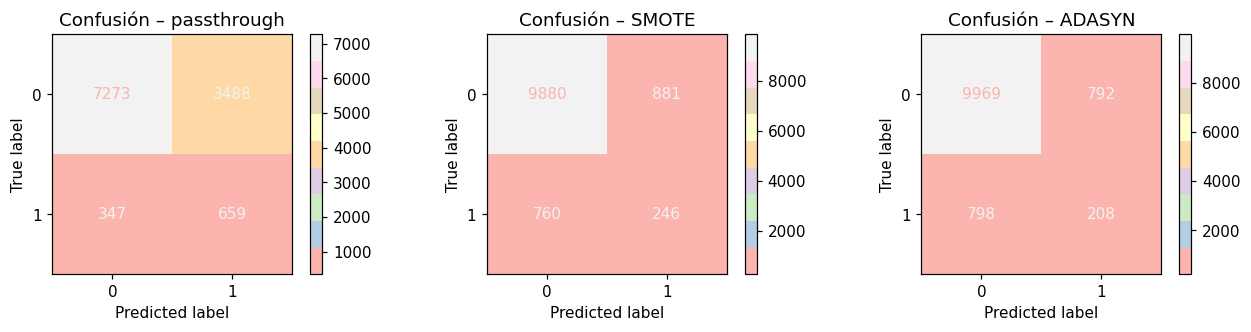

In [9]:
import matplotlib.pyplot as plt, seaborn as sns, numpy as np, xgboost as xgb
from sklearn.metrics import (
    ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
)
sns.set_palette("Pastel1")
plt.rcParams["figure.dpi"] = 110

# ----------------------------------------------------------------
# A. Recolectar boosters / proba / pred por técnica ---------------
# ----------------------------------------------------------------
boosters        = {}
proba_dict      = {}
pred_dict       = {}
evals_hist_dict = {}              # ⬅️ historial de logloss por técnica

for _, row in best_by_sampler.iterrows():
    tech        = row["sampler_name"]
    sampler_opt = row["param_sample"]
    xgb_params  = {k.replace("param_clf__", ""): v
                   for k, v in row.items() if k.startswith("param_clf__")}

    # --- transformar y (si aplica) remuestrear ------------------
    Xtr_p = pre_fitted.transform(X_tr)
    Xval_p= pre_fitted.transform(X_val)
    Xte_p = pre_fitted.transform(X_te)

    if tech == "passthrough":
        Xtr_res, ytr_res = Xtr_p, y_tr
    else:
        sampler = type(sampler_opt)(**sampler_opt.get_params())
        Xtr_res, ytr_res = sampler.fit_resample(Xtr_p, y_tr)

    # --- booster con historial ----------------------------------
    dtrain = xgb.DMatrix(Xtr_res, label=ytr_res)
    dval   = xgb.DMatrix(Xval_p,  label=y_val)
    dtest  = xgb.DMatrix(Xte_p,   label=y_te)

    params = {
        "objective":"binary:logistic",
        "eval_metric":"logloss",
        "tree_method":"hist",
        "learning_rate":float(xgb_params["learning_rate"]),
        "max_depth":int(xgb_params["max_depth"]),
        "scale_pos_weight":float(xgb_params["scale_pos_weight"]),
        "seed":42
    }

    evals_result = {}   # se llenará durante el fit
    booster = xgb.train(
        params,
        dtrain,
        num_boost_round=int(xgb_params["n_estimators"]),
        evals=[(dval, "val")],
        early_stopping_rounds=10,
        evals_result=evals_result,
        verbose_eval=False
    )

    boosters[tech]        = booster
    proba_dict[tech]      = booster.predict(dtest)
    pred_dict[tech]       = (proba_dict[tech] > 0.50).astype(int)
    evals_hist_dict[tech] = evals_result            # guarda historial

# ----------------------------------------------------------------
# B. Matrices de Confusión lado a lado ----------------------------
# ----------------------------------------------------------------
n = len(boosters)
fig, axes = plt.subplots(1, n, figsize=(4*n, 3))

# Asegurar que 'axes' sea siempre iterable
axes = np.atleast_1d(axes)

for ax, (tech, pred) in zip(axes, pred_dict.items()):
    ConfusionMatrixDisplay.from_predictions(
        y_te, pred, ax=ax, cmap="Pastel1"
    )
    ax.set_title(f"Confusión – {tech}")

plt.tight_layout()
plt.show()


## 3.Curvas ROC por técnica de Balanceo

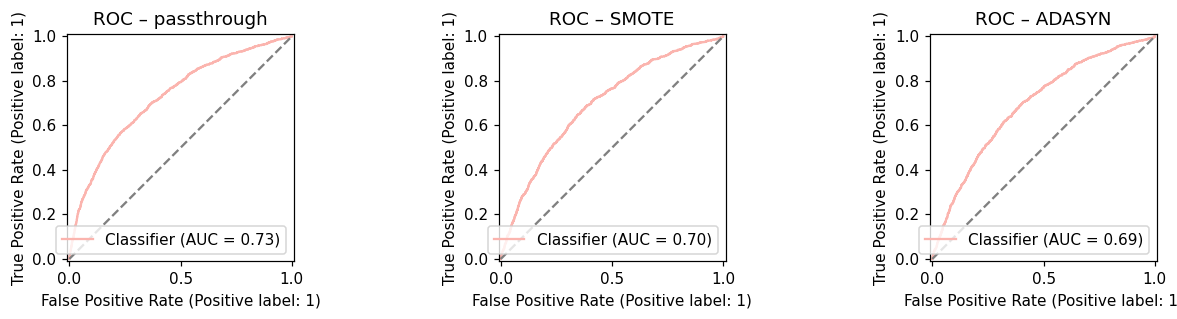

In [10]:
fig, axes = plt.subplots(1, n, figsize=(4*n,3))
if n==1: axes=[axes]
for ax,(tech, proba) in zip(axes, proba_dict.items()):
    RocCurveDisplay.from_predictions(y_te, proba, ax=ax)
    ax.plot([0,1],[0,1],"--", color="gray")
    ax.set_title(f"ROC – {tech}")
plt.tight_layout(); plt.show()


## 4.Curvas ROC por técnica de Balanceo

C:\Users\DELL\AppData\Local\Temp\ipykernel_7928\2211252754.py:4: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
c:\Users\DELL\anaconda3\envs\KrakenData\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


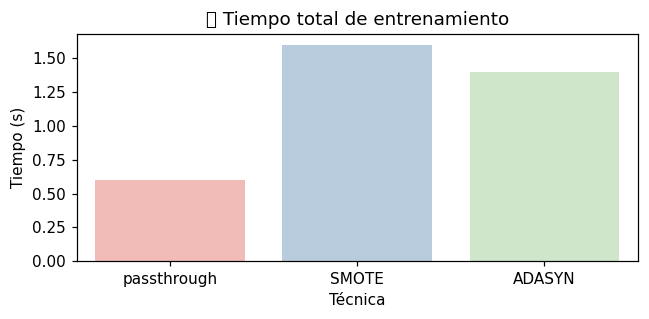

In [11]:
plt.figure(figsize=(6,3))
sns.barplot(x="Técnica", y="Tiempo (s)", data=df_metricas.reset_index())
plt.title("⏱️ Tiempo total de entrenamiento")
plt.tight_layout(); plt.show()

## 5.Tabla de hiperparámetros óptimos

In [12]:
params_tbl = (best_by_sampler
              .filter(regex="param_clf__|sampler_name")
              .set_index("sampler_name")
              .rename_axis("Técnica")
              .rename(columns=lambda c: c.replace("param_clf__","")))
display(params_tbl)


,colsample_bytree,learning_rate,max_depth,n_estimators,scale_pos_weight,subsample
Técnica,,,,,,
passthrough,0.8,0.01,3,200,10.699979,0.8
SMOTE,0.8,0.01,3,200,1.000000,0.8
ADASYN,0.8,0.01,3,200,1.000000,0.8


## 6.Curvas de Aprendizaje y Pérdida

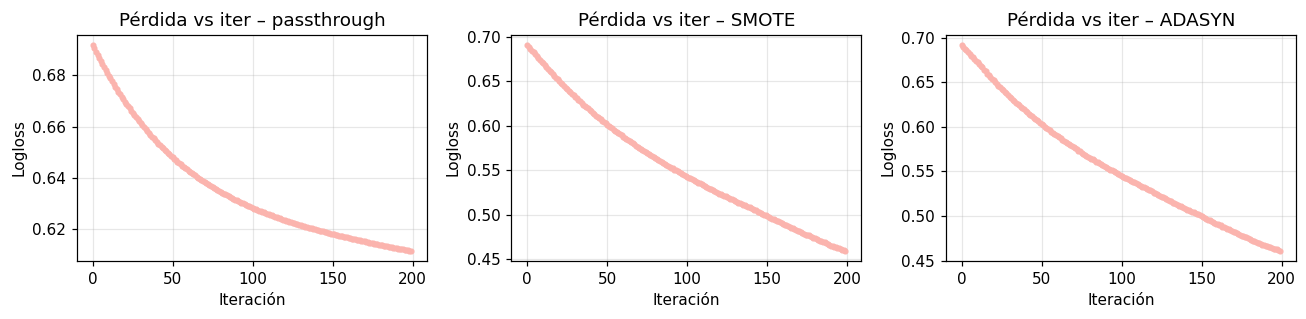

In [13]:
# ---------------------------------------------------------------
# Curvas de pérdida (logloss) por técnica – validación ----------
# ---------------------------------------------------------------
import matplotlib.pyplot as plt, numpy as np, seaborn as sns
sns.set_palette("Pastel1")           # mantiene la paleta unificada

n = len(evals_hist_dict)
fig, axes = plt.subplots(1, n, figsize=(4*n, 3))
axes = np.atleast_1d(axes)          # asegura iterabilidad en n=1

for i, (tech, ev_res) in enumerate(evals_hist_dict.items()):
    # El primer/único key suele ser 'val' o 'validation_0'
    valid_key = list(ev_res.keys())[0]
    logloss   = ev_res[valid_key]["logloss"]

    ax = axes[i]
    ax.plot(logloss, marker="o", markersize=3, linewidth=1.2)
    ax.set_title(f"Pérdida vs iter – {tech}")
    ax.set_xlabel("Iteración")
    ax.set_ylabel("Logloss")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 7.Curva Precision-Recall comparativa

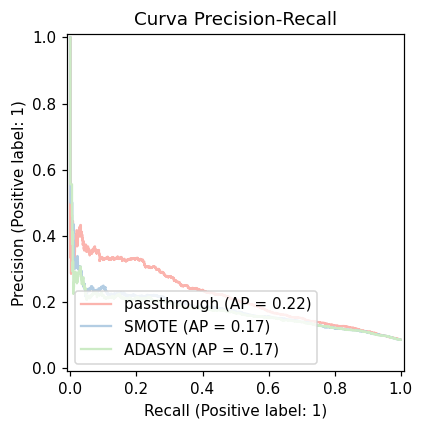

In [14]:
plt.figure(figsize=(6,4))
for tech in boosters:
    PrecisionRecallDisplay.from_predictions(y_te, proba_dict[tech],
                                            name=tech, ax=plt.gca())
plt.title("Curva Precision-Recall")
plt.tight_layout(); plt.show()

## 8.Heatmap de Recall

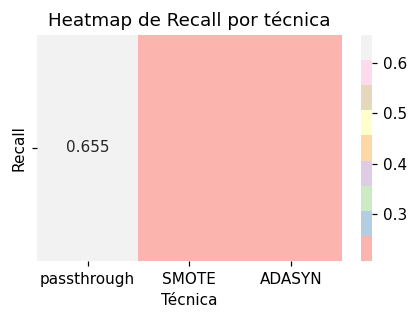

In [15]:
plt.figure(figsize=(4,3))
sns.heatmap(df_metricas[["Recall"]].T, annot=True, fmt=".3f", cmap="Pastel1")
plt.title("Heatmap de Recall por técnica")
plt.tight_layout(); plt.show()

## 9.Radar plot de métricas

In [ ]:
from math import pi
radar_metrics = df_metricas[metric_names]
angles = np.linspace(0, 2*np.pi, len(metric_names), endpoint=False)
angles = np.concatenate((angles,[angles[0]]))
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111, polar=True)
for tech, row in radar_metrics.iterrows():
    values = row.values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, label=tech)
ax.set_xticks(angles[:-1]); ax.set_xticklabels(metric_names)
ax.set_ylim(0, radar_metrics.max().max()*1.1)
ax.set_title("Radar plot métricas")
ax.legend(bbox_to_anchor=(1.1,1)); plt.tight_layout(); plt.show()

KeyError: "['Accuracy', 'F1'] not in index"

## 10.Curvas de Validación (max_depth)

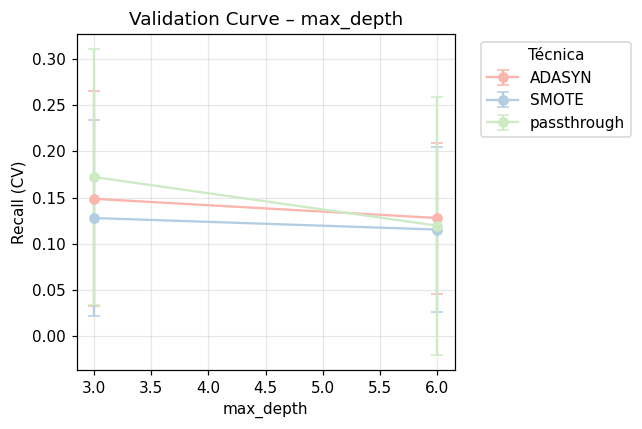

In [ ]:
# ---------------------------------------------------------------
# Validation Curves *sin* reentrenar – usando grid.cv_results_
# ---------------------------------------------------------------
import matplotlib.pyplot as plt, seaborn as sns, numpy as np
sns.set_palette("Pastel1")
plt.rcParams["figure.dpi"] = 110

# 1️⃣  hiperparámetro a analizar -------------------------------
param_name_cv = "param_clf__max_depth"     # cámbialo a otro param_
param_label   = "max_depth"                # para el eje X

# 2️⃣  DataFrame base ------------------------------------------
cv = pd.DataFrame(grid.cv_results_)
cv["sampler_name"] = cv.param_sample.apply(
    lambda s: "passthrough" if s == "passthrough" else type(s).__name__
)

# 3️⃣  Tabla agregada: mean ± std por valor del hiperparámetro --
agg = (cv
       .groupby(["sampler_name", param_name_cv])
       .agg(mean_recall=("mean_test_score", "mean"),
            std_recall =("std_test_score",  "mean"))
       .reset_index())

# 4️⃣  Graficar --------------------------------------------------
plt.figure(figsize=(6,4))

for tech, sub in agg.groupby("sampler_name"):
    # convierte None a np.nan para ordenar correctamente
    x_vals = sub[param_name_cv].apply(lambda v: np.nan if v is None else int(v))
    y      = sub["mean_recall"]
    yerr   = sub["std_recall"]

    plt.errorbar(x_vals, y, yerr=yerr, marker="o",
                 capsize=4, linestyle="-", label=tech)

plt.xlabel(param_label)
plt.ylabel("Recall (CV)")
plt.title(f"Validation Curve – {param_label}")
plt.grid(True, alpha=0.3)
plt.legend(title="Técnica", bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()


## 11.Cumulative Gain & Lift

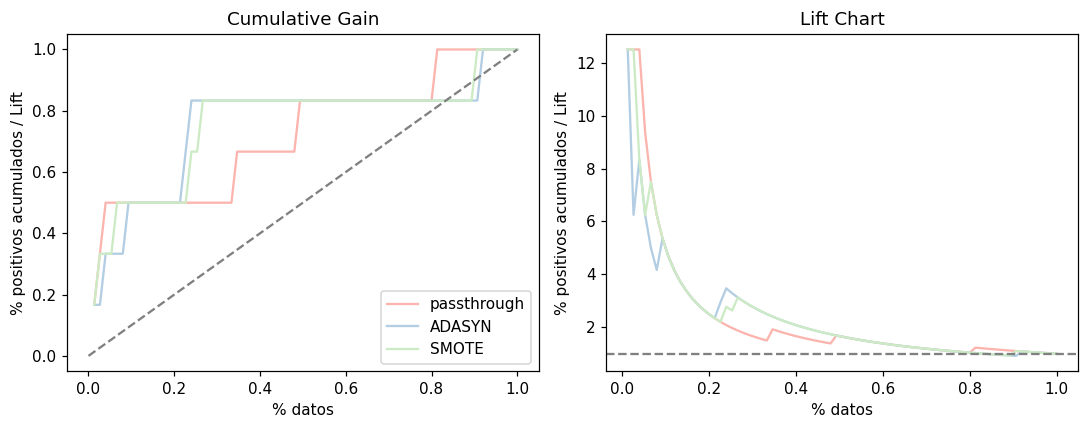

In [ ]:

fig, axes = plt.subplots(1, 2, figsize=(10,4))
for tech, proba in proba_dict.items():
    order = np.argsort(-proba)
    y_sorted = y_te.values[order]
    cum_pos  = np.cumsum(y_sorted)
    pct_data = np.arange(1,len(y_sorted)+1)/len(y_sorted)
    pct_pos  = cum_pos / cum_pos[-1]
    axes[0].plot(pct_data, pct_pos, label=tech)
    axes[1].plot(pct_data, pct_pos/pct_data, label=tech)
axes[0].plot([0,1],[0,1],"--", color="gray")
axes[1].axhline(1, linestyle="--", color="gray")
axes[0].set_title("Cumulative Gain"); axes[1].set_title("Lift Chart")
for ax in axes: ax.set_xlabel("% datos"); ax.set_ylabel("% positivos acumulados / Lift")
axes[0].legend(); plt.tight_layout(); plt.show()

## 12.Curva KS

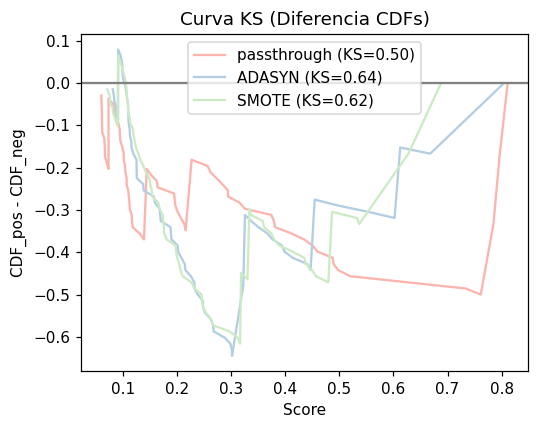

In [ ]:
plt.figure(figsize=(5,4))
for tech, proba in proba_dict.items():
    pos = np.sort(proba[y_te==1]); neg = np.sort(proba[y_te==0])
    cdf_pos = np.arange(1,len(pos)+1)/len(pos)
    cdf_neg = np.arange(1,len(neg)+1)/len(neg)
    thresh  = np.sort(np.concatenate([pos,neg]))
    cdfp_i  = np.searchsorted(pos, thresh, side='right')/len(pos)
    cdfn_i  = np.searchsorted(neg, thresh, side='right')/len(neg)
    ks      = np.max(np.abs(cdfp_i-cdfn_i))
    plt.plot(thresh, cdfp_i-cdfn_i, label=f"{tech} (KS={ks:.2f})")
plt.axhline(0, color="gray"); plt.title("Curva KS (Diferencia CDFs)")
plt.xlabel("Score"); plt.ylabel("CDF_pos - CDF_neg"); plt.legend()
plt.tight_layout(); plt.show()
